# Hyperparameters Tuning
---

In [1]:
import numpy as np
from collections import OrderedDict
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [2]:
# optimizers
class SGD:
    """
    stochastic gradient descent
    lr: learning rate hyperparameter
    """
    
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

class Momentum:
    """
    Momentum SGD
    lr: learning rate hyperparameter (eta in the above)
    momentum: momentum hyperparameter (alpha in the above)
    """
    
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                # initial momentum -> 0
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

class Nesterov:
    """
    Nesterov's Accelerated Gradient
    More aggressive than Momentum optimizer
    However, the backpropagation process needs to be modified
    to implement NAG. See the formula, f, above.
    This is the reason why it can hardly be applied to deep learning.
    Instead, we can use Bengio's approximation like below.
    lr: learning rate hyperparameter (eta in the above)
    momentum: momentum hyperparameter (alpha in the above)
    """
    
    def __init__(self, lr = 0.01, momentum = 0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]

class AdaGrad:
    """
    AdaGrad Optimizer
    lr: a learning rate component (eta in the above)
    self.h: inversely related to lr
    """
    def __init__(self, lr = 0.01):
        self.lr = lr # eta in the above
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key] # Hadamard product
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key] + 1e-7))
            
class RMSProp:
    """
    RMSProp Optimizer
    lr: learning rate hyperparameter (eta in the above)
    gamma: decaying rate hyperparameter (gamma in the above)
    """
    def __init__(self, lr = 0.01, gamma = 0.99):
        self.lr = lr
        self.gamma = gamma
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] = self.gamma * self.h[key] \
            + (1- self.gamma) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key] + 1e-7))
            
class Adam:
    """
    Adam Optimizer
    lr: a learning rate component (eta in the above)
    beta1: a hyperparameter for the Momentum Part
    beta2: a hyperparameter for the RMSProp Part (varying learning rate)
    """
    
    def __init__(self, lr = 0.001, beta1 = 0.9, beta2 = 0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
                
        self.iter += 1
        # modified learning rate (to replace m and v with m_hat and v_hat)
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / \
            (1.0 - self.beta1**self.iter)
        for key in params.keys():
            # Update the Momentum hyperparameter.
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            # Update the RMSProp hyperparameter.
            # Hadamard product can be easily implemented via NumPy operations.
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

In [3]:
# activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(x))

def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis = 0)
        y = np.exp(x) / np.sum(np.exp(x), axis = 0)
        
        return y.T 

    x = x - np.max(x) # preventing overflow
    
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # Convert into groundtruth labels if training data are one-hot encoded.
    if t.size == y.size:
        t = t.argmax(axis = 1)
             
    batch_size = y.shape[0]
    
    return -np.sum(np.log(
        y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [4]:
# activation classes
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

In [5]:
# necessary functions and classes
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # gradients
        self.dW = None
        self.db = None

    def forward(self, x):
        # for tensor operations
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis = 0)
        
        # for tensor operations
        dx = dx.reshape(*self.original_x_shape)
        
        return dx

class SoftMaxWithLoss:
    def __init__(self):
        self.loss = None # loss function
        self.y = None    # SoftMax output
        self.t = None    # groundtruth (one-hot encoded)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout = 1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # if one-hot encoded groundtruth
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags = ['multi_index'], op_flags = ['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x + h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x - h)
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        
        x[idx] = tmp_val # Restore values.
        it.iternext()   
        
    return grad

def shuffle_dataset(x, t):
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation, :] if x.ndim == 2 else x[permutation, :, :, :]
    t = t[permutation]

    return x, t

In [6]:
class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum = 0.9,
                 running_mean = None, running_var = None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # CNN: 4-dimensional, FCL: 2-dimensional
        
        # for back prop
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None
        
        # for test (validation)
        self.running_mean = running_mean
        self.running_var = running_var
        
    def forward(self, x, train_flg = True):
        self.input_shape = x.shape
        if x.ndim != 2: # in case of CNN
            N, C, H, W = x.shape
            x = x.reshape(N, -1)
            
        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape) # Restore the original shape.
    
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
            
        if train_flg: # training
            mu = x.mean(axis = 0)
            xc = x - mu
            var = np.mean(xc**2, axis = 0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean +\
            (1 - self.momentum) * mu
            self.running_var = self.momentum * self.running_var +\
            (1 - self.momentum) * var
        else: # validation
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta
        
        return out
    
    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)
            
        dx = self.__backward(dout)
        dx = dx.reshape(*self.input_shape)
        
        return dx
    
    def __backward(self, dout): # If repeat node, sum!!!
        dbeta = dout.sum(axis = 0)
        dgamma = np.sum(self.xn * dout, axis = 0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis = 0)
        dvar = 0.5 * dstd / self.std
        dvar /= self.batch_size # mean node
        dxc += dvar * (2.0 * self.xc)
        dmu = -np.sum(dxc, axis = 0)
        dx = dxc + (dmu / self.batch_size) # the 2nd factor: mean node
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx

In [7]:
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio = 0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

the number of Affine = the number of hidden + 1 + 1
<br>$\rightarrow$ 1: Input Layer, Output Layer
<br>
the number of Batch Normalization = the number of hidden + 1
<br>$\rightarrow$ 1: Input Layer
<br>
the number of Dropout = the number of hidden + 1
<br>$\rightarrow$ 1: Input Layer

In [8]:
class MultiLayerNetExtend:
    """ Fully Connected Layer
    Parameters
    ----------
    input_size : 784 if MNIST
    hidden_size_list : the number of neurons in a hidden layer（e.g. [100, 100, 100]）
    output_size : 10 if MNIST
    activation : 'ReLU' or 'Sigmoid'
    weight_init_std : e.g. 0.01
        'ReLU' or 'He' -> Set He Initialization.
        'Sigmoid' or 'Xavier' -> Set Xavier Initialization.
    weight_decay_lambda : regularization parameter
    use_dropout : True or False
    dropout_ratio : Dropout Ratio
    use_batchNorm : True or False
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation = 'ReLU', weight_init_std = 'ReLU',
                 weight_decay_lambda = 0, use_dropout = False,
                 dropout_ratio = 0.5, use_batchnorm = False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # weight initialization
        self.__init_weight(weight_init_std)

        # the order of layers: Affine + Batch Norm + Activation + Dropout
        # creating hidden layers (Affine + activation per hidden layer)
        activation_layer = {'Sigmoid': Sigmoid, 'ReLU': ReLU}
        self.layers = OrderedDict()
        
        # input layer and hidden layers
        for idx in range(1, self.hidden_layer_num + 1):
            self.layers['Affine' + str(idx)] = Affine(
                self.params['W' + str(idx)],
                self.params['b' + str(idx)])
            
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(
                    hidden_size_list[idx -1])
                self.params['beta' + str(idx)] = np.zeros(
                    hidden_size_list[idx - 1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(
                    self.params['gamma' + str(idx)],
                    self.params['beta' + str(idx)])
            
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ratio)

        # the output layer's Affine
        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(
            self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        # cross entropy (not SoftMax function)
        self.last_layer = SoftMaxWithLoss()

    def __init_weight(self, weight_init_std):
        """
        Weight Initialization Parameters
        ----------
        weight_init_std : e.g. 0.01
            'ReLU' or 'He' -> Set He Initialization.
            'Sigmoid' or 'Xavier' -> Set Xavier Initialization.
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        # range: We do not need to consider the output layer's
        # weight initialization.
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                # recommended if ReLU
                scale = np.sqrt(2.0 / all_size_list[idx - 1])
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                # recommended if Sigmoid
                scale = np.sqrt(1.0 / all_size_list[idx - 1])
            self.params['W' + str(idx)] = scale * np.random.randn(
                all_size_list[idx - 1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg = False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                # You need to additionally apply a SoftMax function
                # to get predicted values.
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg = False):
        y = self.predict(x, train_flg)

        weight_decay = 0
        # self.hidden_layer_num + 2: hidden layers
        # + (input layer + output layer)
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda *\
            np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x, train_flg = False)
        y = np.argmax(y, axis = 1)
        # unless one-hot encoded groundtruth
        # ex) one-hot encoded: t = [[0, 0, 1, 0, ..., 0],
        #                           [1, 0, 0, 0, ..., 0],
        #                           [0, 1, 0, 0, ..., 0]] -> t.ndim = 2
        # ex) not one-hot encoded: t = [2, 0, 1] -> t.ndim = 1
        if t.ndim != 1: t = np.argmax(t, axis = 1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t, train_flg = True)

        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads['W' + str(idx)] = numerical_gradient(
                loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(
                loss_W, self.params['b' + str(idx)])
            
            if self.use_batchnorm and idx != self.hidden_layer_num + 1:
                grads['gamma' + str(idx)] = numerical_gradient(
                    loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(
                    loss_W, self.params['beta' + str(idx)])

        return grads

    # back propagation
    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg = True)
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # Store results.
        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            # L2-Regularization assumed (differentiated by weights)
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW +\
            self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db
            
            if self.use_batchnorm and idx != self.hidden_layer_num + 1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads

In [29]:
class Trainer:
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs = 20, mini_batch_size = 100,
                 optimizer = 'SGD', optimizer_param = {'lr': 0.01}, 
                 evaluate_sample_num_per_epoch = None, verbose = True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd': SGD, 'momentum': Momentum,
                                'nesterov': Nesterov, 'adagrad': AdaGrad,
                                'rmsprpo': RMSProp, 'adam': Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("Training Loss: " + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== Epoch: " + str(self.current_epoch) +\
                                   ", Training Acc: " + str(train_acc) +\
                                   ", Test Acc: " + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("Test Acc: " + str(test_acc))

In [30]:
def __train(lr, weight_decay, epochs = 50):
    network = MultiLayerNetExtend(input_size = 784,
                                  hidden_size_list = [100, 100, 100, 100, 100, 100],
                                  output_size = 10, weight_decay_lambda = weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs = epochs, mini_batch_size = 100,
                      optimizer = 'sgd', optimizer_param = {'lr': lr},
                      verbose = False)
    trainer.train()
    
    return trainer.test_acc_list, trainer.train_acc_list

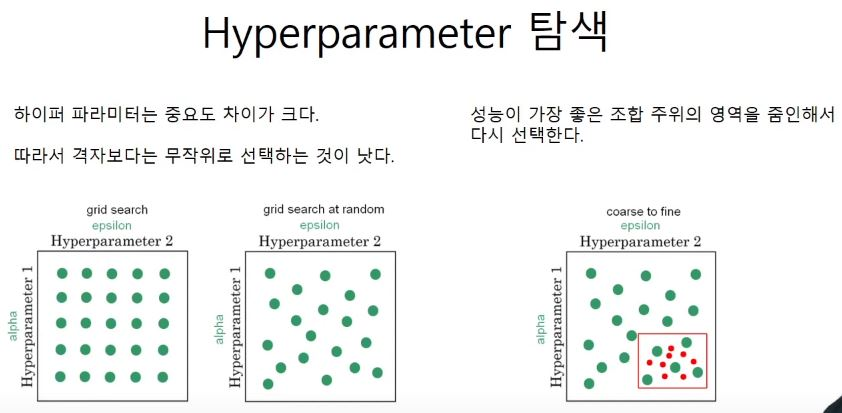

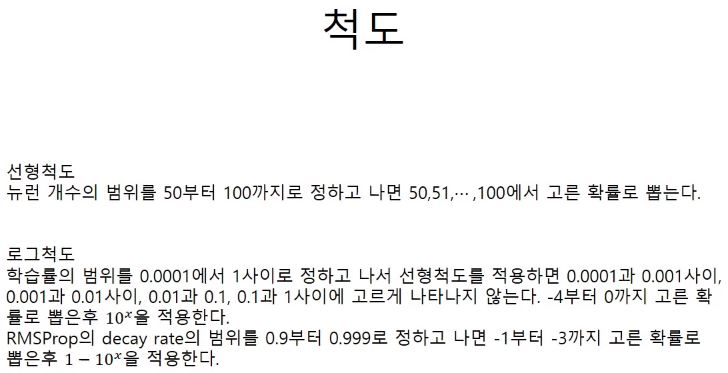

In [31]:
# input data
(x_train, t_train), (x_test, t_test) = mnist.load_data()

# normalization
x_train = (x_train - 0.0) / (255.0 - 0.0)

x_train = x_train[:500].reshape(500, 784)
t_train = t_train[:500]

# validation set
validation_rate = 0.20
num_validation = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:num_validation]
t_val = t_train[:num_validation]
x_train = x_train[num_validation:]
t_train = t_train[num_validation:]

In [32]:
# hyperparameter random search
optimization_trial = 100
results_val = {}
results_training = {}
for _ in range(optimization_trial):
    # hyperparameter ranges
    weight_decay = 10**np.random.uniform(-8, -4)
    lr = 10**np.random.uniform(-6, -2)
    
    val_acc_list, training_acc_list = __train(lr, weight_decay)
    print("Val Acc: " + str(val_acc_list[-1]) +\
          " | lr: " + str(round(lr, 3)) + ", Weight Decay: " +\
          str(round(weight_decay, 3)))
    key = "lr: " + str(round(lr, 3)) + ", Weight Decay: " +\
    str(round(weight_decay, 3))
    results_val[key] = val_acc_list
    results_training[key] = training_acc_list

Val Acc: 0.15 | lr: 1.012679988655849e-05, Weight Decay: 1.0951849106662427e-07
Val Acc: 0.19 | lr: 0.00024364658141280555, Weight Decay: 4.223967437156377e-06
Val Acc: 0.78 | lr: 0.008185651768313061, Weight Decay: 5.027520587240702e-06
Val Acc: 0.12 | lr: 0.00012327636018525078, Weight Decay: 2.6390884001547414e-08
Val Acc: 0.17 | lr: 8.489462571964926e-05, Weight Decay: 2.4916084797547188e-08
Val Acc: 0.08 | lr: 9.011611349952303e-06, Weight Decay: 5.761629292666965e-07
Val Acc: 0.11 | lr: 1.5589365336708332e-06, Weight Decay: 1.324077438082068e-08
Val Acc: 0.15 | lr: 0.0008662429147884061, Weight Decay: 1.0951914162281118e-08
Val Acc: 0.05 | lr: 2.1832496550869114e-06, Weight Decay: 2.8078085353418485e-07
Val Acc: 0.21 | lr: 0.00031625836004829427, Weight Decay: 2.106960882184158e-05
Val Acc: 0.17 | lr: 7.70274929674147e-06, Weight Decay: 2.0124032717313917e-08
Val Acc: 0.04 | lr: 1.5979324455545879e-06, Weight Decay: 1.7763436925913263e-08
Val Acc: 0.11 | lr: 4.757879235485625e-05

========== Hyperparameter Optimization Result ==========
Best-1 (Val Acc: 0.83) | lr: 0.007097924770997039, Weight Decay: 7.864275909553345e-07
Best-2 (Val Acc: 0.78) | lr: 0.008185651768313061, Weight Decay: 5.027520587240702e-06
Best-3 (Val Acc: 0.72) | lr: 0.005598872293277986, Weight Decay: 5.224354868363829e-05
Best-4 (Val Acc: 0.69) | lr: 0.0058665178178942306, Weight Decay: 1.300121683353145e-08
Best-5 (Val Acc: 0.67) | lr: 0.0045404216301298695, Weight Decay: 1.3729937503115379e-06
Best-6 (Val Acc: 0.56) | lr: 0.005619320133117039, Weight Decay: 7.536011417729408e-07
Best-7 (Val Acc: 0.55) | lr: 0.003984705313603315, Weight Decay: 1.2382306606034726e-05
Best-8 (Val Acc: 0.43) | lr: 0.002344834531550956, Weight Decay: 3.720188285743604e-06
Best-9 (Val Acc: 0.36) | lr: 0.0009107409526781418, Weight Decay: 6.003103374015676e-07
Best-10 (Val Acc: 0.36) | lr: 0.0018791962202367259, Weight Decay: 3.343222681718079e-06
Best-11 (Val Acc: 0.34) | lr: 0.0026488608342126185, Weight Decay:

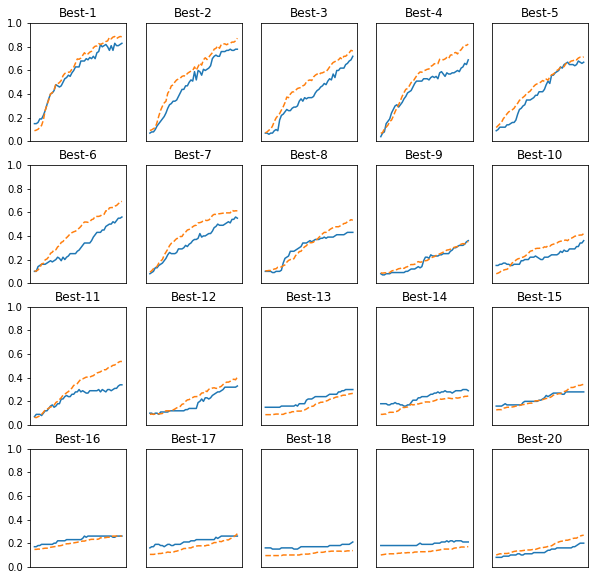

In [33]:
# graph
print("=" * 10 + " Hyperparameter Optimization Result " + "=" * 10)
num_graph_draw = 20
num_col = 5
num_row = int(np.ceil(num_graph_draw / num_col))
i = 0

plt.figure(figsize = (10, 10))

# x[1] -> value (x[1] -> value) // x[1][-1] -> the last value
for key, val_acc_list in sorted(results_val.items(),
                                key = lambda x:x[1][-1], reverse = True):
    print("Best-" + str(i + 1) + " (Val Acc: " +\
          str(round(val_acc_list[-1], 3)) + ") | " + key)
    
    plt.subplot(num_row, num_col, i + 1)
    plt.title("Best-" + str(i + 1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_training[key], "--")
    i += 1
    
    if i >= num_graph_draw:
        break
        
plt.show()